In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
series = pd.read_excel('/content/sample_data/wind_mill_dataset.xlsx',index_col="DateTime")
series.head()

,Air temperature (Â°C),Pressure (atm),Wind speed (m/s),Wind direction (deg),Power generated by system (kW)
DateTime,,,,,
01-01-2022 6:25:08,46,1.566323,7.821116,110,1575.282483
01-01-2022 19:07:48,47,0.244996,2.451113,209,2709.400866
01-01-2022 14:35:28,26,1.269813,13.170429,0,456.224206
01-01-2022 10:47:12,22,0.247692,1.427477,57,3394.727121
01-01-2022 7:29:58,23,0.141071,2.763579,92,3625.480094


In [ ]:
# Cleaning Data
series['Power_generated_by_system (kW)'].replace(0, np.nan, inplace=True)
series['Power_generated_by_system (kW)'].fillna(method='ffill', inplace=True)
print(series)

                     Air temperature (Â°C)  Pressure (atm)  Wind speed (m/s)  \
DateTime                                                                       
01-01-2022 6:25:08                      46        1.566323          7.821116   
01-01-2022 19:07:48                     47        0.244996          2.451113   
01-01-2022 14:35:28                     26        1.269813         13.170429   
01-01-2022 10:47:12                     22        0.247692          1.427477   
01-01-2022 7:29:58                      23        0.141071          2.763579   
...                                    ...             ...               ...   
25-03-2022 07:22:45                     37        0.796958          3.516333   
25-03-2022 20:05:42                     13        0.633826         17.915798   
25-03-2022 14:03:06                     22        0.934775         10.932041   
25-03-2022 00:17:15                     24        0.571159         10.088716   
25-03-2022 02:59:44                     

In [ ]:
# initialize variables
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 12
lag_exp=24

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
# scale train and test data to [-1, 1]
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [ ]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
# fit an LSTM network to training data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [ ]:
print(series.columns)

Index(['Air temperature (Â°C)', 'Pressure (atm)', 'Wind speed (m/s)',
       'Wind direction (deg)', 'Power generated by system (kW)'],
      dtype='object')


In [ ]:
# Drop all the features as we will not be having any in production
del series['Air_temperature (c)']
del series['Pressure (atm)']
del series['Wind_speed (m/s)']
del series['Wind_direction (deg)']

In [ ]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Power generated by system (kW)
DateTime,
23-03-2022 21:07:47,2767.000134
23-03-2022 04:33:32,1811.464992
23-03-2022 23:47:54,1825.256388
23-03-2022 08:51:58,4397.086551
23-03-2022 02:55:42,196.217880


In [ ]:
# create a differenced series
from pandas import Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [ ]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [ ]:
# Print the raw and differenced values
print("Raw values:", raw_values)
print("Differenced values:", diff_values)

Raw values: [[4.60000000e+01 1.56632286e+00 7.82111570e+00 1.10000000e+02
  1.57528248e+03]
 [4.70000000e+01 2.44995724e-01 2.45111345e+00 2.09000000e+02
  2.70940087e+03]
 [2.60000000e+01 1.26981332e+00 1.31704292e+01 0.00000000e+00
  4.56224206e+02]
 ...
 [2.20000000e+01 9.34774671e-01 1.09320412e+01 1.56000000e+02
  3.17512283e+03]
 [2.40000000e+01 5.71159233e-01 1.00887155e+01 2.93000000e+02
  2.21435253e+03]
 [1.40000000e+01 1.92322288e+00 3.42416586e+00 1.24000000e+02
  2.45570485e+03]]
Differenced values: 0       [1.0, -1.3213271381, -5.370002247, 99.0, 1134....
1       [-21.0, 1.0248175941, 10.719315697, -209.0, -2...
2       [-4.0, -1.0221212646, -11.742952189, 57.0, 293...
3       [1.0, -0.10662077819999999, 1.3361021970000002...
4       [-15.0, 1.6777877317999998, 2.7211555719999994...
                              ...                        
1994    [21.0, 0.18994970590000004, 2.0716285560000003...
1995    [-24.0, -0.16313149660000004, 14.3994649390000...
1996    [9.0, 0.30

In [ ]:
# frame a sequence as a supervised learning problem
from pandas import DataFrame
from pandas import concat
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [ ]:
# Print the supervised values
print("Supervised values:", supervised_values)

In [ ]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [ ]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

1931/1931 [==============================] - 7s 3ms/step - loss: 0.0877


In [ ]:
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
test_pred = list()
 #Classify power level using CNN
def classify_power_level(prediction, low_threshold, high_threshold):
    if prediction < low_threshold:
        return 'low'
    elif prediction >= high_threshold:
        return 'high'
    else:
        return 'mid'



# Set your low and high thresholds
low_threshold = 1000
high_threshold = 2500

# Display Hour, Predicted, Expected, and Classified Power Level
expectations = np.array([])
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)  # make one-step forecast
    test_pred = np.array([yhat] + list(test_pred))  # Convert to numpy array for concatenation
    if i + 1 < len(test_scaled):
        end_idx = min(len(test_scaled[i+1]), len(test_pred))
        test_scaled[i + 1] = np.concatenate((test_pred[:end_idx], test_scaled[i + 1, end_idx:]), axis=0)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    predictions = np.append(predictions, yhat)  # Use np.append instead
    expected = raw_values[len(train) + i + 1]
    expectations = np.append(expectations, expected)  # Add expected value to the array
    classified_power_level = classify_power_level(yhat, low_threshold, high_threshold)
    print('Hour=%d, Predicted=%f, Expected=%f, Classified=%s' % (i + 1, yhat, expected, classified_power_level))

1/1 [==============================] - 0s 346ms/step
Hour=1, Predicted=209.179468, Expected=1258.322175, Classified=low
1/1 [==============================] - 0s 15ms/step
Hour=2, Predicted=2261.199996, Expected=2147.745618, Classified=mid
1/1 [==============================] - 0s 15ms/step
Hour=3, Predicted=1709.063535, Expected=2437.202369, Classified=mid
1/1 [==============================] - 0s 17ms/step
Hour=4, Predicted=2850.903367, Expected=690.138045, Classified=high
1/1 [==============================] - 0s 16ms/step
Hour=5, Predicted=1119.085405, Expected=3366.957896, Classified=mid
1/1 [==============================] - 0s 15ms/step
Hour=6, Predicted=2130.635273, Expected=2980.690308, Classified=mid
1/1 [==============================] - 0s 16ms/step
Hour=7, Predicted=3900.464197, Expected=1472.320494, Classified=high
1/1 [==============================] - 0s 22ms/step
Hour=8, Predicted=1589.572052, Expected=68.299417, Classified=mid
1/1 [==============================] - 0s

In [ ]:
# Convert predictions and expectations to numpy arrays
expectations = np.array(expectations)
predictions = np.array(predictions)

# Calculate MAPE
mape = np.mean(np.abs((expectations - predictions) / expectations)) * 100
print("Mean Absolute Percent Error: ", mape)

Mean Absolute Percent Error:  245.18716460617185


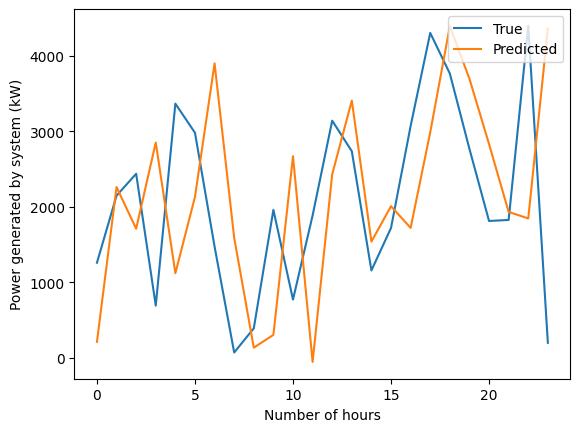

In [ ]:
from matplotlib import pyplot
pyplot.plot(raw_values[-predict_values_exp:], label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [ ]:
from keras.models import save_model

# Save the model
lstm_model.save('lstm_model.h5')

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Define the function to normalize input features
def normalize_features(features):
    # Assuming the original range for each feature was 0 to 100
    return features / 100.0

# Define the function to denormalize the prediction
def denormalize_prediction(prediction):
    # Assuming the denormalization range for power is 0 to 6000 kW
    return abs(prediction) * 6000.0

# Load the trained LSTM model
lstm_model = load_model('/content/lstm_model.h5')

# Take user input for the four features
air_temperature = float(input("Enter air temperature (°C): "))
pressure = float(input("Enter pressure (atm): "))
wind_speed = float(input("Enter wind speed (m/s): "))
wind_direction = float(input("Enter wind direction (deg): "))

# Normalize the input features
input_features = np.array([[air_temperature, pressure, wind_speed, wind_direction]])
normalized_features = normalize_features(input_features)

# Expand the input features to match the expected shape (batch_size, 1, 24)
normalized_features_expanded = np.zeros((normalized_features.shape[0], 1, 24))
normalized_features_expanded[:, :, :4] = normalized_features

# Make a prediction using the LSTM model
prediction = lstm_model.predict(normalized_features_expanded)

# Denormalize the prediction
predicted_power = denormalize_prediction(prediction[0][0])

# Display the predicted power output
print("Predicted power generated by the system:", predicted_power, "kW")